In [149]:
%matplotlib inline
import math
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

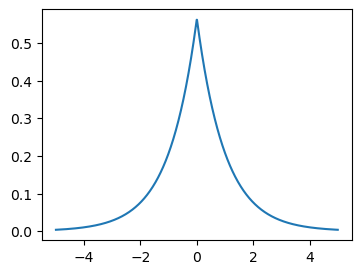

In [150]:
x = np.linspace(-5,5,num=1000)
r = abs(x)
zeta = 1.0
psi_STO = (zeta**3/np.pi)**(0.5)*np.exp(-zeta*r)

plt.figure(figsize=(4,3))
plt.plot(x,psi_STO)

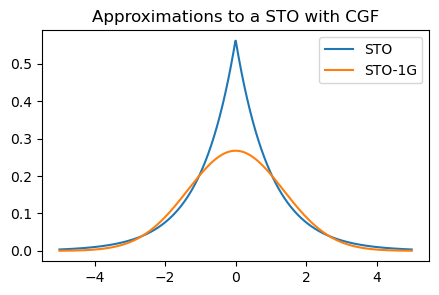

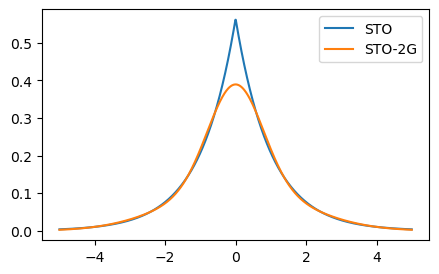

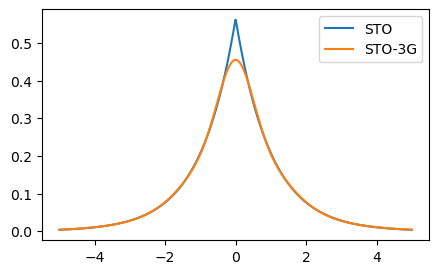

In [151]:
# Coeff is the d_n variable in the equation above
Coeff = np.array(
    [[1.00000, 0.0000000, 0.000000], [0.678914, 0.430129, 0.000000], [0.444635, 0.535328, 0.154329]]
)

# Expon is the alpha variable in the equation above
Expon = np.array(
    [[0.270950, 0.000000, 0.000000], [0.151623, 0.851819, 0.000000], [0.109818, 0.405771, 2.227660]]
)

psi_CGF_STO1G = Coeff[0, 0] * (2 * Expon[0, 0] / np.pi) ** (0.75) * np.exp(-Expon[0, 0] * r**2)
psi_CGF_STO2G = (
    Coeff[1, 0] * (2 * Expon[1, 0] / np.pi) ** (0.75) * np.exp(-Expon[1, 0] * r**2)
    + Coeff[1, 1] * (2 * Expon[1, 1] / np.pi) ** (0.75) * np.exp(-Expon[1, 1] * r**2)
    + Coeff[1, 2] * (2 * Expon[1, 2] / np.pi) ** (0.75) * np.exp(-Expon[1, 2] * r**2)
)
psi_CGF_STO3G = (
    Coeff[2, 0] * (2 * Expon[2, 0] / np.pi) ** (0.75) * np.exp(-Expon[2, 0] * r**2)
    + Coeff[2, 1] * (2 * Expon[2, 1] / np.pi) ** (0.75) * np.exp(-Expon[2, 1] * r**2)
    + Coeff[2, 2] * (2 * Expon[2, 2] / np.pi) ** (0.75) * np.exp(-Expon[2, 2] * r**2)
)

# Plot the three functions
plt.figure(figsize=(5, 3))
plt.title("Approximations to a STO with CGF")
plt.plot(x, psi_STO, label="STO")
plt.plot(x, psi_CGF_STO1G, label="STO-1G")
plt.legend()
plt.figure(figsize=(5, 3))
plt.plot(x, psi_STO, label="STO")
plt.plot(x, psi_CGF_STO2G, label="STO-2G")
plt.legend()
plt.figure(figsize=(5, 3))
plt.plot(x, psi_STO, label="STO")
plt.plot(x, psi_CGF_STO3G, label="STO-3G")
plt.legend()

## Setup variables

In [152]:
global H, S, X, XT, TT, G, C, P, Oldp, F, Fprime, Cprime, E

H = np.zeros([2, 2])
S = np.zeros([2, 2])
X = np.zeros([2, 2])
XT = np.zeros([2, 2])
TT = np.zeros([2, 2, 2, 2])
G = np.zeros([2, 2])
C = np.zeros([2, 2])

P = np.zeros([2, 2])
Oldp = np.zeros([2, 2])
F = np.zeros([2, 2])
Fprime = np.zeros([2, 2])
Cprime = np.zeros([2, 2])
E = np.zeros([2, 2])

Energy = 0.0
Delta = 0.0

IOP = 2
N = 3
R = 1.4632
Zeta1 = 2.0925
Zeta2 = 1.24
Za = 2.0
Zb = 1.0

## Prepare ingradients for SCF Calculation

In [153]:
def F0(t):
    """
    F function for 1s orbital
    """
    if t < 1e-6:
        return 1.0 - t / 3.0
    else:
        return 0.5 * (np.pi / t) ** 0.5 * sp.erf(t**0.5)

In [154]:
def S_int(A, B, Rab2):
    """
    Calculates the overlap between two gaussian functions
    """
    return (np.pi / (A + B)) ** 1.5 * np.exp(-A * B * Rab2 / (A + B))

In [155]:
def T_int(A, B, Rab2):
    """
    Calculates the kinetic energy integrals for un-normalised primitives
    """
    return (
        A
        * B
        / (A + B)
        * (3.0 - 2.0 * A * B * Rab2 / (A + B))
        * (np.pi / (A + B)) ** 1.5
        * np.exp(-A * B * Rab2 / (A + B))
    )

In [156]:
def V_int(A, B, Rab2, Rcp2, Zc):
    """
    Calculates the un-normalised nuclear attraction integrals
    """
    V = 2.0 * np.pi / (A + B) * F0((A + B) * Rcp2) * np.exp(-A * B * Rab2 / (A + B))

    return -V * Zc

In [157]:
def erf(t):
    """
    Approximation for the error function
    """
    P = 0.3275911
    A = [0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429]
    T = 1.0 / (1 + P * t)
    Tn = T
    Poly = A[0] * Tn

    for i in range(1, 5):
        Tn = Tn * T
        Poly = Poly * A[i] * Tn

    return 1.0 - Poly * np.exp(-t * t)

In [158]:
def TwoE(A, B, C, D, Rab2, Rcd2, Rpq2):
    """
    Calculate two electron integrals
    A,B,C,D are the exponents alpha, beta, etc.
    Rab2 equals squared distance between center A and center B
    """
    return (
        2.0
        * (np.pi**2.5)
        / ((A + B) * (C + D) * np.sqrt(A + B + C + D))
        * F0((A + B) * (C + D) * Rpq2 / (A + B + C + D))
        * np.exp(-A * B * Rab2 / (A + B) - C * D * Rcd2 / (C + D))
    )

In [159]:
def Intgrl(N, R, Zeta1, Zeta2, Za, Zb):
    """
    Declares the variables and compiles the integrals.
    """

    global S12, T11, T12, T22, V11A, V12A, V22A, V11B, V12B, V22B, V1111, V2111, V2121, V2211, V2221, V2222

    S12 = 0.0
    T11 = 0.0
    T12 = 0.0
    T22 = 0.0
    V11A = 0.0
    V12A = 0.0
    V22A = 0.0
    V11B = 0.0
    V12B = 0.0
    V22B = 0.0
    V1111 = 0.0
    V2111 = 0.0
    V2121 = 0.0
    V2211 = 0.0
    V2221 = 0.0
    V2222 = 0.0

    R2 = R * R

    # The coefficients for the contracted Gaussian functions are below
    Coeff = np.array(
        [[1.00000, 0.0000000, 0.000000], [0.678914, 0.430129, 0.000000], [0.444635, 0.535328, 0.154329]]
    )

    Expon = np.array(
        [[0.270950, 0.000000, 0.000000], [0.151623, 0.851819, 0.000000], [0.109818, 0.405771, 2.227660]]
    )
    D1 = np.zeros([3])
    A1 = np.zeros([3])
    D2 = np.zeros([3])
    A2 = np.zeros([3])

    # This loop constructs the contracted Gaussian functions
    for i in range(N):
        A1[i] = Expon[N - 1, i] * (Zeta1**2)
        D1[i] = Coeff[N - 1, i] * ((2.0 * A1[i] / np.pi) ** 0.75)
        A2[i] = Expon[N - 1, i] * (Zeta2**2)
        D2[i] = Coeff[N - 1, i] * ((2.0 * A2[i] / np.pi) ** 0.75)

    # Calculate one electron integrals
    # Centre A is first atom centre B is second atom
    # Origin is on second atom
    # V12A - off diagonal nuclear attraction to centre A etc.
    for i in range(N):
        for j in range(N):
            # Rap2 - squared distance between centre A and centre P
            Rap = A2[j] * R / (A1[i] + A2[j])
            Rap2 = Rap**2
            Rbp2 = (R - Rap) ** 2
            S12 = S12 + S_int(A1[i], A2[j], R2) * D1[i] * D2[j]
            T11 = T11 + T_int(A1[i], A1[j], 0.0) * D1[i] * D1[j]
            T12 = T12 + T_int(A1[i], A2[j], R2) * D1[i] * D2[j]
            T22 = T22 + T_int(A2[i], A2[j], 0.0) * D2[i] * D2[j]
            V11A = V11A + V_int(A1[i], A1[j], 0.0, 0.0, Za) * D1[i] * D1[j]
            V12A = V12A + V_int(A1[i], A2[j], R2, Rap2, Za) * D1[i] * D2[j]
            V22A = V22A + V_int(A2[i], A2[j], 0.0, R2, Za) * D2[i] * D2[j]
            V11B = V11B + V_int(A1[i], A1[j], 0.0, R2, Zb) * D1[i] * D1[j]
            V12B = V12B + V_int(A1[i], A2[j], R2, Rbp2, Zb) * D1[i] * D2[j]
            V22B = V22B + V_int(A2[i], A2[j], 0.0, 0.0, Zb) * D2[i] * D2[j]

    # Calculate two electron integrals

    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    Rap = A2[i] * R / (A2[i] + A1[j])
                    Rbp = R - Rap
                    Raq = A2[k] * R / (A2[k] + A1[l])
                    Rbq = R - Raq
                    Rpq = Rap - Raq
                    Rap2 = Rap * Rap
                    Rbp2 = Rbp * Rbp
                    Raq2 = Raq * Raq
                    Rbq2 = Rbq * Rbq
                    Rpq2 = Rpq * Rpq
                    V1111 = (
                        V1111
                        + TwoE(A1[i], A1[j], A1[k], A1[l], 0.0, 0.0, 0.0) * D1[i] * D1[j] * D1[k] * D1[l]
                    )
                    V2111 = (
                        V2111
                        + TwoE(A2[i], A1[j], A1[k], A1[l], R2, 0.0, Rap2) * D2[i] * D1[j] * D1[k] * D1[l]
                    )
                    V2121 = (
                        V2121 + TwoE(A2[i], A1[j], A2[k], A1[l], R2, R2, Rpq2) * D2[i] * D1[j] * D2[k] * D1[l]
                    )
                    V2211 = (
                        V2211 + TwoE(A2[i], A2[j], A1[k], A1[l], 0.0, 0.0, R2) * D2[i] * D2[j] * D1[k] * D1[l]
                    )
                    V2221 = (
                        V2221
                        + TwoE(A2[i], A2[j], A2[k], A1[l], 0.0, R2, Rbq2) * D2[i] * D2[j] * D2[k] * D1[l]
                    )
                    V2222 = (
                        V2222
                        + TwoE(A2[i], A2[j], A2[k], A2[l], 0.0, 0.0, 0.0) * D2[i] * D2[j] * D2[k] * D2[l]
                    )
    return

In [160]:
def Collect():
    """
    Takes the basic integrals and assembles the relevant matrices,
    that are S, H, X, XT and two electron integrals
    """
    # Form core hamiltonian
    H[0, 0] = T11 + V11A + V11B
    H[0, 1] = T12 + V12A + V12B
    H[1, 0] = H[0, 1]
    H[1, 1] = T22 + V22A + V22B

    # Form overlap matrix
    S[0, 0] = 1.0
    S[0, 1] = S12
    S[1, 0] = S12
    S[1, 1] = 1.0

    # This is S^-1/2
    X[0, 0] = 1.0 / np.sqrt(2.0 * (1.0 + S12))
    X[1, 0] = X[0, 0]
    X[0, 1] = 1.0 / np.sqrt(2.0 * (1.0 - S12))
    X[1, 1] = -X[0, 1]

    # This is the coulomb and exchange term (aa|bb) and (ab|ba)
    TT[0, 0, 0, 0] = V1111
    TT[1, 0, 0, 0] = V2111
    TT[0, 1, 0, 0] = V2111
    TT[0, 0, 1, 0] = V2111
    TT[0, 0, 0, 1] = V2111
    TT[1, 0, 1, 0] = V2121
    TT[0, 1, 1, 0] = V2121
    TT[1, 0, 0, 1] = V2121
    TT[0, 1, 0, 1] = V2121
    TT[1, 1, 0, 0] = V2211
    TT[0, 0, 1, 1] = V2211
    TT[1, 1, 1, 0] = V2221
    TT[1, 1, 0, 1] = V2221
    TT[1, 0, 1, 1] = V2221
    TT[0, 1, 1, 1] = V2221
    TT[1, 1, 1, 1] = V2222

## Prepare SCF calculator


In [161]:
def Diag(Fprime, Cprime, E):
    """
    Diagonalises F to give eigenvectors in C and eigen values in E, theta is the angle describing the solution
    """
    # Angle for heteronuclear diatonic
    Theta = 0.5 * math.atan(2.0 * Fprime[0, 1] / (Fprime[0, 0] - Fprime[1, 1]))
    # print('Theta', Theta)

    Cprime[0, 0] = np.cos(Theta)
    Cprime[1, 0] = np.sin(Theta)
    Cprime[0, 1] = np.sin(Theta)
    Cprime[1, 1] = -np.cos(Theta)

    E[0, 0] = (
        Fprime[0, 0] * np.cos(Theta) ** 2
        + Fprime[1, 1] * np.sin(Theta) ** 2
        + Fprime[0, 1] * np.sin(2.0 * Theta)
    )
    E[1, 1] = (
        Fprime[1, 1] * np.cos(Theta) ** 2
        + Fprime[0, 0] * np.sin(Theta) ** 2
        - Fprime[0, 1] * np.sin(2.0 * Theta)
    )

    if E[1, 1] <= E[0, 0]:
        Temp = E[1, 1]
        E[1, 1] = E[0, 0]
        E[0, 0] = Temp
        Temp = Cprime[0, 1]
        Cprime[0, 1] = Cprime[0, 0]
        Cprime[0, 0] = Temp
        Temp = Cprime[1, 1]
        Cprime[1, 1] = Cprime[1, 0]
        Cprime[1, 0] = Temp
    return

In [162]:
def SCF(R, Za, Zb, G):
    """
    Performs the SCF iterations
    """
    Crit = 1e-11  # Convergence critera
    Maxit = 250  # Maximum number of iterations
    Iter = 0

    #--------
    # STEP 1. Guess an initial density matrix
    #--------
    # Use core hamiltonian for initial guess of F (P = 0)
    P = np.zeros([2, 2])

    Energy = 0.0

    while Iter < Maxit:
        Iter += 1

        #--------
        # STEP 2. Calculate the Fock matrix 
        #--------
        # Form two electron part of Fock matrix from P
        # This is the two electron contribution in the equations above
        G = np.zeros([2, 2])  
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    for l in range(2):
                        G[i, j] = G[i, j] + P[k, l] * (TT[i, j, k, l] - 0.5 * TT[i, l, k, j])

        # Add core hamiltonian H^CORE to get Fock matrix
        F = H + G

        # Calculate the electronic energy
        Energy = np.sum(0.5 * P * (H + F))

        #--------
        # STEP 3. Calculate F' 
        # (remember S^-1/2 is X and S^1/2 is X.T) 
        #--------
        G = np.matmul(F, X)
        Fprime = np.matmul(X.T, G)

        #--------
        # STEP 4. Solve the eigenvalue problem 
        #--------
        # Diagonalise transformed Fock matrix
        Diag(Fprime, Cprime, E)

        #--------
        # STEP 5. Calculate the molecular orbitals coefficients 
        #--------
        # Transform eigen vectors to get matrix C
        C = np.matmul(X, Cprime)

        # STEP 6. Calculate the new density matrix from the old P 
        Oldp = np.array(P)
        P = np.zeros([2, 2])

        # Form new density matrix
        for i in range(2):
            for j in range(2):
                # Save present density matrix before creating a new one
                for k in range(1):
                    P[i, j] += 2.0 * C[i, k] * C[j, k]

        #--------
        # STEP 7. Check to see if the energy has converged 
        #--------
        Delta = 0.0
        # Calculate delta the difference between the old and 
        # new density matrix (Old P and new P)
        Delta = P - Oldp
        Delta = np.sqrt(np.sum(Delta**2) / 4.0)

        print("Step ", Iter, " Elec Energy", Energy, " Diff", Delta)

        # Check for convergence
        if Delta < Crit:
            # Add nuclear repulsion to get the total energy
            Energy_tot = Energy + Za * Zb / R
            print("")
            print("Calculation converged with electronic energy:", Energy)
            print("Calculation converged with total energy:", Energy_tot)
            print("Density matrix")
            print(P)
            print("Mulliken populations")
            print(np.matmul(P, S))
            print("Coeffients")
            print(C)

            break

### Let's perform calculation!

In [163]:
# Calculate one and two electron integrals
Intgrl(N, R, Zeta1, Zeta2, Za, Zb)
# Put all integals into array
Collect()
# Perform the SCF calculation
SCF(R, Za, Zb, G)

Step  1  Elec Energy 0.0  Diff 0.8828668530136917
Step  2  Elec Energy -4.141862876133925  Diff 0.2791763040686421
Step  3  Elec Energy -4.22649189912899  Diff 0.029661780077229444
Step  4  Elec Energy -4.227522925343759  Diff 0.0023182848695558057
Step  5  Elec Energy -4.227529268100319  Diff 0.00017439769686161983
Step  6  Elec Energy -4.227529304014095  Diff 1.3079512369092073e-05
Step  7  Elec Energy -4.227529304216109  Diff 9.807146593527476e-07
Step  8  Elec Energy -4.227529304217244  Diff 7.353368030466615e-08
Step  9  Elec Energy -4.22752930421725  Diff 5.5135252472270695e-09
Step  10  Elec Energy -4.227529304217251  Diff 4.1340208808251866e-10
Step  11  Elec Energy -4.227529304217252  Diff 3.099665019964731e-11
Step  12  Elec Energy -4.227529304217252  Diff 2.3244357915420586e-12

Calculation converged with electronic energy: -4.227529304217252
Calculation converged with total energy: -2.86066216370331
Density matrix
[[1.28614168 0.54017322]
 [0.54017322 0.22687011]]
Mulliken 

<BarContainer object of 6 artists>

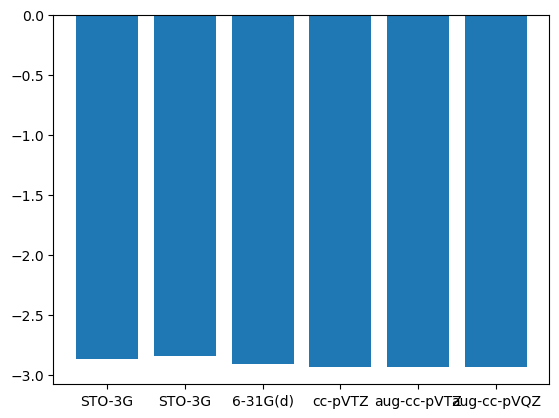

In [164]:
plt.bar(
    [1, 2, 3, 4, 5, 6],
    [
        -2.8669283534318275,
        -2.8418364990824458,
        -2.9098394146425748,
        -2.9322482557926945,
        -2.9322713663802804,
        -2.932878077558255,
    ],
    tick_label=["STO-3G", "STO-3G", "6-31G(d)", "cc-pVTZ", "aug-cc-pVTZ", "aug-cc-pVQZ"],
)